# Setup

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset

# Read Data as Numpy Array

In [76]:
# load training data
training_data = np.load("Data/training_data.npy", allow_pickle=True)
print("training data shape: {}".format(training_data.shape))

training data shape: (170, 2)


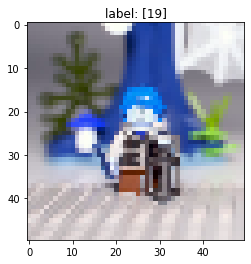

In [77]:
# plot example image
plt.imshow(training_data[0][0])
plt.title("label: {}".format(training_data[0][1]));

In [73]:
# augment and normalize images
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])    
])

In [84]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Batch idx 0, data shape torch.Size([10, 3, 50, 50]), target shape torch.Size([10, 1])
Batch idx 1, data shape torch.Size([10, 3, 50, 50]), target shape torch.Size([10, 1])
Batch idx 2, data shape torch.Size([10, 3, 50, 50]), target shape torch.Size([10, 1])
Batch idx 3, data shape torch.Size([10, 3, 50, 50]), target shape torch.Size([10, 1])
Batch idx 4, data shape torch.Size([10, 3, 50, 50]), target shape torch.Size([10, 1])
Batch idx 5, data shape torch.Size([10, 3, 50, 50]), target shape torch.Size([10, 1])
Batch idx 6, data shape torch.Size([10, 3, 50, 50]), target shape torch.Size([10, 1])
Batch idx 7, data shape torch.Size([10, 3, 50, 50]), target shape torch.Size([10, 1])
Batch idx 8, data shape torch.Size([10, 3, 50, 50]), target shape torch.Size([10, 1])
Batch idx 9, data shape torch.Size([10, 3, 50, 50]), target shape torch.Size([10, 1])
Batch idx 10, data shape torch.Size([10, 3, 50, 50]), target shape torch.Size([10, 1])
Batch idx 11, data shape torch.Size([10, 3, 50, 50]),

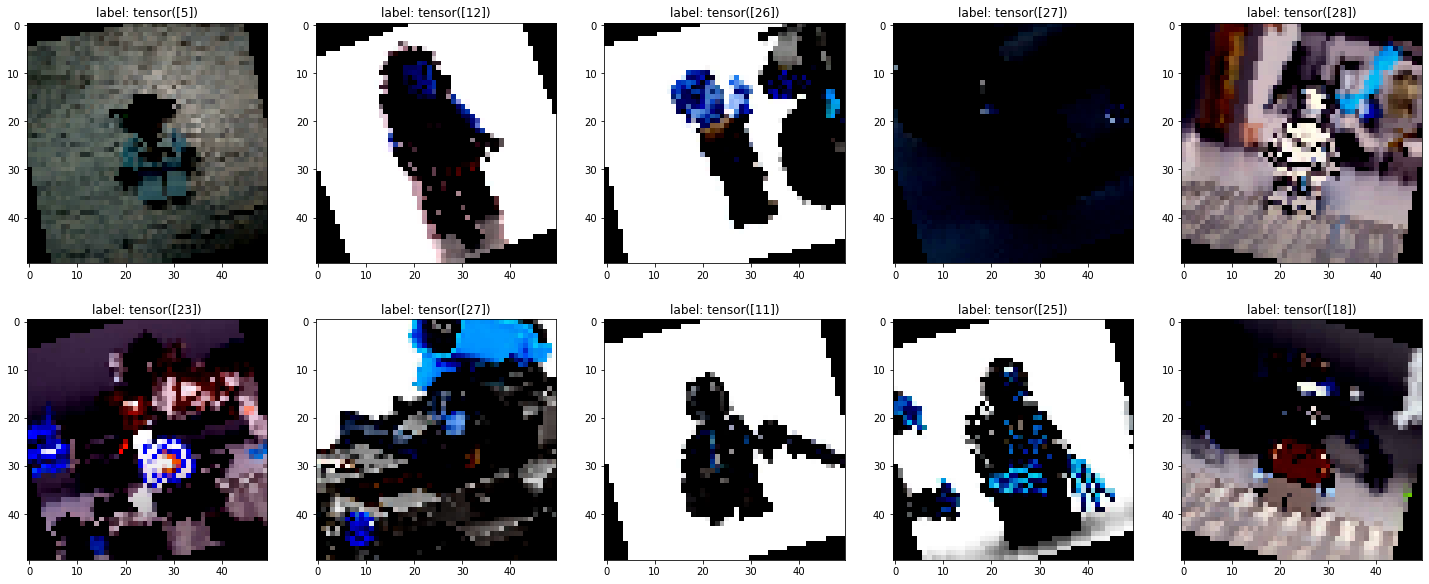

In [127]:
dataset = MyDataset(training_data[:,0][:], training_data[:,1][:], transform=transforms)
loader = DataLoader(dataset,
                    batch_size=10,
                    shuffle=True)


for batch_idx, (data, target) in enumerate(loader):
    print('Batch idx {}, data shape {}, target shape {}'.format(
        batch_idx, data.shape, target.shape))
    
# plot images from last batch
fig, axes = plt.subplots(2,5, figsize=(25,10))

for i, ax in enumerate(axes.flatten()): 
    tmp = data[i].numpy().swapaxes(0,1)
    tmp1 = tmp.swapaxes(1,2)
    
    ax.imshow(tmp1)
    ax.set_title(f"label: {target[i]}");